If in Google Drive, set to True

In [2]:
inDrive = True

### Setup

Set working directory

In [3]:
import os
import sys

# Get current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

# Add parent directory to Python path
parent_dir = os.path.dirname(cwd)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

Current working directory: /content


Drive stuff

In [4]:
if inDrive:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir('/content/drive/MyDrive/Hybrid-CLUE')
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: /content/drive/MyDrive/Hybrid-CLUE


Imports

In [6]:
import torch
from torchvision import datasets, transforms
import pickle as pickle
from src.utils import evaluate_vae

Set device

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

### Optional: Set device to CPU

In [ ]:
device = torch.device('cpu')

### Load the VAE


In [8]:
%matplotlib inline
from VAE.MNISTconv_bern import MNISTconv_VAE_bern_net
from VAE.train import train_VAE
from VAE.models import MNIST_generator_resnet, MNIST_recognition_resnet
import importlib
import src.utils
importlib.reload(src.utils)

save_dir = '../notebooks/saves'
new_save_dir = './my-saves'


latent_dim = 20

batch_size = 64
nb_epochs = 300
lr = 7e-4
early_stop = 60

encoder = MNIST_recognition_resnet(latent_dim)
decoder = MNIST_generator_resnet(latent_dim)

VAE = MNISTconv_VAE_bern_net(latent_dim, encoder, decoder, lr, device=device)
VAE.new_load(new_save_dir+'/VAE_20d_MNIST.pt', device)


Net:
VAE_bern_net
    Total params: 1.33M
Reading ./my-saves/VAE_20d_MNIST.pt

Loading model to device: cuda


/content/drive/MyDrive/Hybrid-CLUE/src/utils.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=device)


  Restored epoch: 140, lr: 0.0007


140

### Load the BNN

First we import the relevant libraries and set the working directory

The cell below can be used to reload the BNN code if it has been changed

In [9]:
import importlib # Import the importlib module
import BNN

from BNN.models import MLP
from BNN.wrapper import BNN_cat
from BNN.train import train_BNN_classification

importlib.reload(BNN.models)  # Contains MLP
importlib.reload(BNN.wrapper) # Contains BNN_cat
importlib.reload(BNN.train)  # Contains train_BNN_classification

from BNN.models import MLP
from BNN.wrapper import BNN_cat
from BNN.train import train_BNN_classification

Next we load the BNN model

In [17]:
%matplotlib inline

input_dim = 784
width = 1200
depth = 2
output_dim = 10
model = MLP(input_dim, width, depth, output_dim, flatten_image=False)

N_train = 60000

lr = 1e-2

N_saves = 300
# N_saves = 5

BNN = BNN_cat(model, N_train, lr=lr, device=device)

save_dir = './my-saves/'
weights_path = save_dir + 'state_dicts.pt'

if os.path.exists(weights_path):
    BNN.load_weights(weights_path)
else:
    print(f"Weights file not found at: {weights_path}")



Net:
BNN categorical output
    Total params: 2.40M
Loading weight samples from ./my-saves/state_dicts.pt
File size: 2741.68 MB
Loaded object type: <class 'list'>
Number of weight samples: 300


### Load the original BNN

First we import the relevant libraries and set the working directory

The cell below can be used to reload the BNN code if it has been changed

In [ ]:
import importlib # Import the importlib module
import BNN

from BNN.models import MLP
from BNN.wrapper import BNN_cat
from BNN.train import train_BNN_classification

importlib.reload(BNN.models)  # Contains MLP
importlib.reload(BNN.wrapper) # Contains BNN_cat
importlib.reload(BNN.train)  # Contains train_BNN_classification

from BNN.models import MLP
from BNN.wrapper import BNN_cat
from BNN.train import train_BNN_classification

Next we load the BNN model

In [ ]:
%matplotlib inline

input_dim = 784
width = 1200
depth = 2
output_dim = 10
model = MLP(input_dim, width, depth, output_dim, flatten_image=False)

N_train = 60000

lr = 1e-2

N_saves = 300
# N_saves = 5

BNN = BNN_cat(model, N_train, lr=lr, device=device)

save_dir = '../original_saves/'
weights_path = save_dir + 'original_state_dicts.pkl'

if os.path.exists(weights_path):
    BNN.load_weights(weights_path)
else:
    print(f"Weights file not found at: {weights_path}")


### Load the datasets



In [15]:
if BNN.device.type != VAE.device.type:
    print(f"Device mismatch: BNN on {BNN.device}, VAE on {VAE.device}")

transform_train = transforms.Compose([
    transforms.ToTensor(),
    #     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

batch_size = 1024

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=BNN.device.type == 'cuda', num_workers=3)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=BNN.device.type == 'cuda', num_workers=3)

In [18]:
import numpy as np
from importlib import reload
import interpret.visualization_tools
reload(interpret.visualization_tools)
from interpret.visualization_tools import latent_project_MNIST


torch.cuda.empty_cache()

# tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train = \
#     latent_project_MNIST(BNN, VAE, dset=trainset, batch_size=1024, cuda=cuda, flatten_BNN=True, flatten_VAE=False)

te_aleatoric_vec, te_epistemic_vec, z_test, x_test, y_test = \
    latent_project_MNIST(BNN, VAE, dset=valset, batch_size=256, flatten_BNN=True, flatten_VAE=False)

torch.cuda.empty_cache()

te_uncertainty_vec = te_aleatoric_vec + te_epistemic_vec

uncert_idxs_sorted = np.flipud(np.argsort(te_aleatoric_vec + te_epistemic_vec))


Text(0, 0.5, 'Uncertainty')

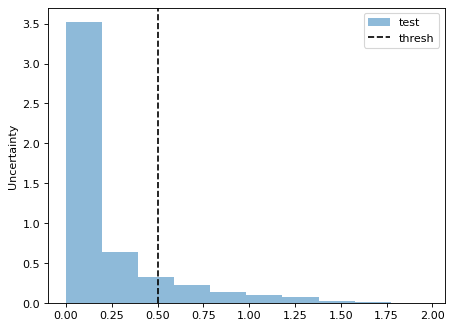

In [19]:
import matplotlib.pyplot as plt

H_thresh_MNIST = 0.5

plt.figure(dpi=80)
plt.hist(te_uncertainty_vec, density=True, alpha=0.5, label='test')
plt.axvline(x=H_thresh_MNIST, color='k', linestyle='--', label='thresh')
plt.legend()
plt.ylabel('Uncertainty')

In [20]:
Nbatch = 40
z_init_batch = z_test[uncert_idxs_sorted[:Nbatch]]
x_init_batch = x_test[uncert_idxs_sorted[:Nbatch]]
y_init_batch = y_test[uncert_idxs_sorted[:Nbatch]]

## Test calibration of BNN


In [21]:
from sklearn.calibration import calibration_curve

def plot_reliability_diagram(y_true, pred_classes, max_probs, n_bins=10, model_name='BNN', ax=None):
    """
    Plot reliability diagram for multiclass classification
    y_true: true labels
    pred_classes: predicted classes
    max_probs: confidence scores (maximum probability)
    ax: matplotlib axes to plot on
    """
    if ax is None:
        ax = plt.gca()

    # Convert y_true to 0 and 1 for binary classification
    y_true_binary = (y_true == pred_classes).astype(int)

    prob_true, prob_pred = calibration_curve(y_true_binary,
                                           max_probs,
                                           n_bins=n_bins,
                                           strategy='uniform')

    ax.plot(prob_pred, prob_true, marker='o', label=model_name)
    ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Observed Frequency')
    ax.set_title('Reliability Diagram')
    ax.legend()

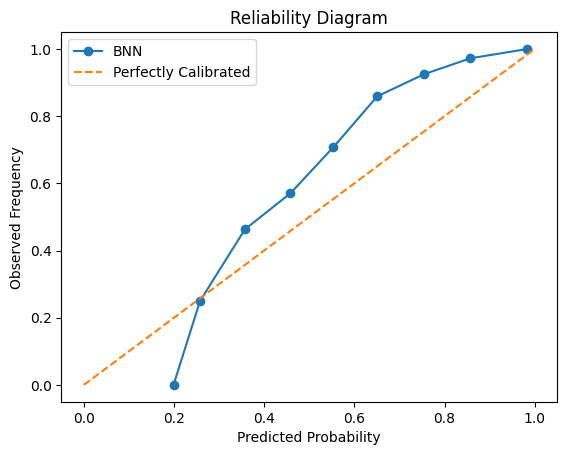

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from src.utils import MNIST_mean_std_norm

# Get BNN predictions on test set
x_test_processed = MNIST_mean_std_norm(torch.tensor(x_test).reshape(x_test.shape[0], -1))
# Move tensor to the same device as BNN
x_test_processed = x_test_processed.to(BNN.device)
# Use sample_predict instead of direct call
probs = BNN.sample_predict(x_test_processed, Nsamples=0, grad=False)

# For multiclass case, we'll use the maximum probability as confidence
max_probs_BNN = probs.mean(dim=0).max(dim=1)[0].detach().cpu().numpy()
pred_classes = probs.mean(dim=0).argmax(dim=1).detach().cpu().numpy()

# Plot calibration curve
plot_reliability_diagram(y_test, pred_classes, max_probs_BNN)

Epoch 1, Loss: 0.2576, Test Accuracy: 98.39%
Epoch 2, Loss: 0.0634, Test Accuracy: 99.04%
Epoch 3, Loss: 0.0429, Test Accuracy: 99.28%
Epoch 4, Loss: 0.0373, Test Accuracy: 99.32%
Epoch 5, Loss: 0.0293, Test Accuracy: 99.22%
Epoch 6, Loss: 0.0262, Test Accuracy: 99.26%
Epoch 7, Loss: 0.0224, Test Accuracy: 99.41%
Epoch 8, Loss: 0.0201, Test Accuracy: 99.37%
Epoch 9, Loss: 0.0177, Test Accuracy: 99.35%
Epoch 10, Loss: 0.0175, Test Accuracy: 99.32%


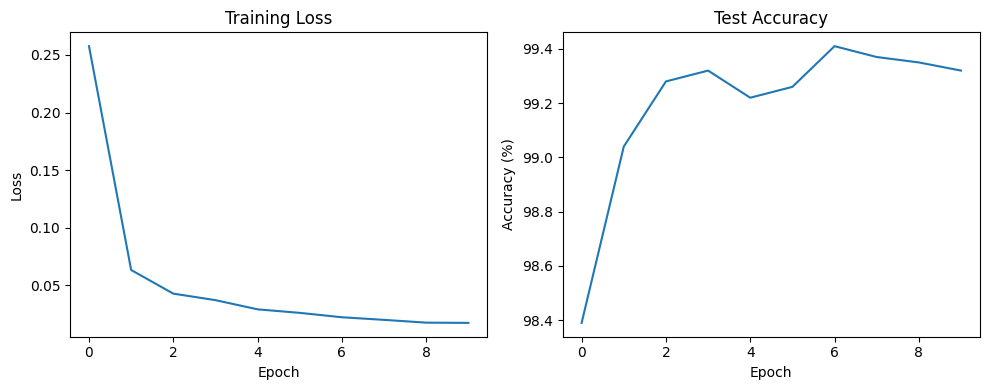

In [23]:
# Train a regular CNN for comparison
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Match BNN_cat architecture
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)  # 28x28 -> 28x28
        self.pool1 = nn.MaxPool2d(2, 2)  # 28x28 -> 14x14

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # 14x14 -> 14x14
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)  # 14x14 -> 14x14
        self.pool2 = nn.MaxPool2d(2, 2)  # 14x14 -> 7x7

        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Reshape to [batch, channels, height, width]

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout(x)

        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Initialize model and move to same device as BNN
cnn = SimpleCNN().to(BNN.device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(cnn.parameters())

# Training loop
n_epochs = 10
batch_size = 128

# Create DataLoaders with num_workers=0 to avoid multiprocessing issues
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                      shuffle=False, num_workers=0)

# Train using the DataLoader
train_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    cnn.train()
    running_loss = 0.0

    # Train on batches from trainloader
    for batch_x, batch_y in trainloader:
        batch_x = batch_x.to(BNN.device)
        batch_y = batch_y.to(BNN.device)

        optimizer.zero_grad()
        outputs = cnn(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Evaluate on validation set
    cnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in valloader:
            batch_x = batch_x.to(BNN.device)
            batch_y = batch_y.to(BNN.device)
            outputs = cnn(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = 100 * correct / total
    train_losses.append(running_loss/len(trainloader))
    test_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, Test Accuracy: {accuracy:.2f}%')

# Plot training curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()

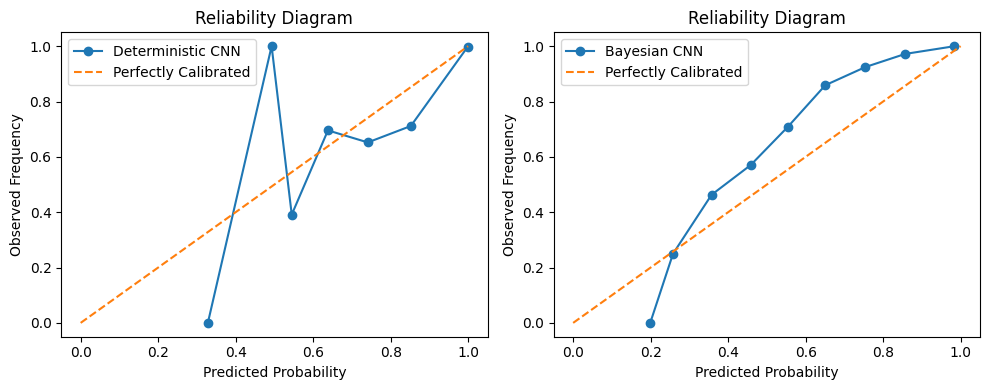

In [24]:
# Get predictions and confidence scores from trained CNN
cnn.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in valloader:
        batch_x = batch_x.to(BNN.device)
        outputs = cnn(batch_x)
        probs = F.softmax(outputs, dim=1)
        max_probs, predicted = torch.max(probs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(max_probs.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot on the first subplot
plot_reliability_diagram(all_labels, all_preds, all_probs, n_bins=10,
                        model_name='Deterministic CNN', ax=ax1)

# Plot on the second subplot
plot_reliability_diagram(y_test, pred_classes, max_probs_BNN,
                        model_name='Bayesian CNN', ax=ax2)

plt.tight_layout()
plt.show()


## Old code for CLUE


In [ ]:
print(x_init_batch.shape)

In [ ]:
from interpret.CLUE import CLUE
import importlib
import interpret.CLUE
importlib.reload(interpret.CLUE)
from interpret.CLUE import CLUE

from src.utils import Ln_distance

# batch_size = 10

torch.cuda.empty_cache()

dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch.reshape(x_init_batch.shape[0], -1).shape[1]
distance_weight = 25 / x_dim



# z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec = \
# CLUE.batch_optimise(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
#                       prior_weight=0, distance_weight=distance_weight,
#                  latent_L2_weight=0, prediction_similarity_weight=0,
#                  lr=1e-1,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
#                       flatten_BNN=True,
#                  regression=False, cuda=True, batch_size=batch_size, min_steps=3, max_steps=25, n_early_stop=3)


CLUE_explainer = CLUE(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
                      prior_weight=0, distance_weight=distance_weight,
                 latent_L2_weight=0, prediction_similarity_weight=0,
                 lr=1,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
                      flatten_BNN=True,
                 regression=False, cuda=False)

torch.autograd.set_detect_anomaly(False)

# clue_instance.optimizer = SGD(self.trainable_params, lr=lr, momentum=0.5, nesterov=True)
z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = CLUE_explainer.optimise(
    min_steps=3, max_steps=20, n_early_stop=3 )

fig, axes = plt.subplots(1, 3, dpi=130)
axes[0].plot(cost_vec.mean(axis=1))
axes[0].set_title('mean Cost')
axes[0].set_xlabel('iterations')

axes[1].plot(uncertainty_vec.mean(axis=1))
axes[1].set_title('mean Total Entropy')
axes[1].set_xlabel('iterations')

axes[2].plot(dist_vec.mean(axis=1))
axes[2].set_title('mean Ln Cost')
axes[2].set_xlabel('iterations')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

In [ ]:
# Verify device placement
print(f"BNN device: {BNN.device}")
print(f"VAE device: {VAE.device}")

# Test CLUE
### Run CLUE


Step 1/20
Step 2/20
Step 3/20
Step 4/20
Step 5/20
it 4, all conditions met, stopping
Step 6/20
it 5, all conditions met, stopping
Step 7/20
it 6, all conditions met, stopping
Step 8/20
it 7, all conditions met, stopping
Step 9/20
it 8, all conditions met, stopping
Step 10/20
it 9, all conditions met, stopping
Step 11/20
it 10, all conditions met, stopping
Step 12/20
it 11, all conditions met, stopping
Step 13/20
it 12, all conditions met, stopping
Step 14/20
it 13, all conditions met, stopping
Step 15/20
it 14, all conditions met, stopping
Step 16/20
it 15, all conditions met, stopping
Step 17/20
it 16, all conditions met, stopping
Step 18/20
it 17, all conditions met, stopping
Step 19/20
it 18, all conditions met, stopping
Step 20/20
it 19, all conditions met, stopping


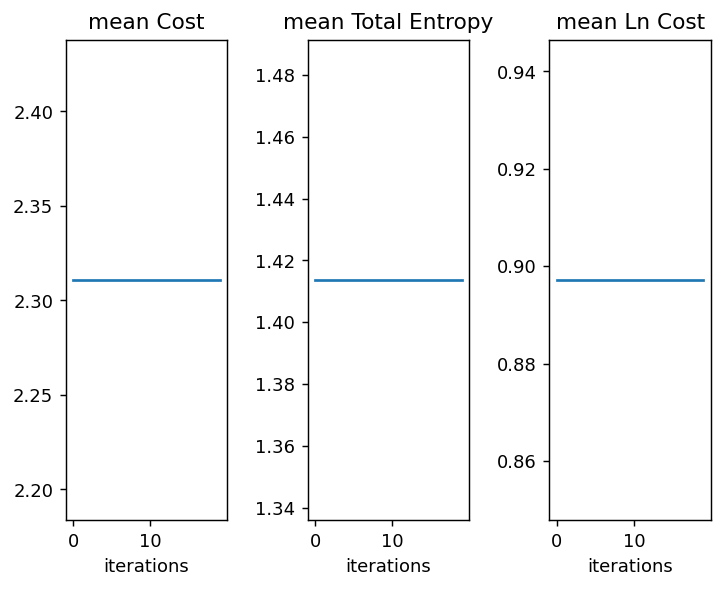

In [25]:
import importlib
import interpret.CLUE
importlib.reload(interpret.CLUE)
from interpret.CLUE import CLUE
from src.utils import Ln_distance

# batch_size = 10

torch.cuda.empty_cache()

dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch.reshape(x_init_batch.shape[0], -1).shape[1]
distance_weight = 25 / x_dim


# z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec = \
# CLUE.batch_optimise(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
#                       prior_weight=0, distance_weight=distance_weight,
#                  latent_L2_weight=0, prediction_similarity_weight=0,
#                  lr=1e-1,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
#                       flatten_BNN=True,
#                  regression=False, cuda=True, batch_size=batch_size, min_steps=3, max_steps=25, n_early_stop=3)

# Convert input tensors to device
# x_init_batch = x_init_batch.to(device)
# z_init_batch = z_init_batch.to(device) if z_init_batch is not None else None

torch.autograd.set_detect_anomaly(True)


CLUE_explainer = CLUE(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
                      prior_weight=0, distance_weight=distance_weight,
                 latent_L2_weight=0, prediction_similarity_weight=0,
                 lr=1e-1,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
                      flatten_BNN=True,
                 regression=False)

# # Move CLUE's internal tensors to device
CLUE_explainer.to(device)

# clue_instance.optimizer = SGD(self.trainable_params, lr=lr, momentum=0.5, nesterov=True)
z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = CLUE_explainer.optimise(
     min_steps=3, max_steps=20, n_early_stop=3 )

fig, axes = plt.subplots(1, 3, dpi=130)
axes[0].plot(cost_vec.mean(axis=1))
axes[0].set_title('mean Cost')
axes[0].set_xlabel('iterations')

axes[1].plot(uncertainty_vec.mean(axis=1))
axes[1].set_title('mean Total Entropy')
axes[1].set_xlabel('iterations')

axes[2].plot(dist_vec.mean(axis=1))
axes[2].set_title('mean Ln Cost')
axes[2].set_xlabel('iterations')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)


In [ ]:
delta_x = np.abs(x_init_batch - x_vec[-1]).sum(axis=(1,2,3))
delta_H = te_uncertainty_vec[uncert_idxs_sorted[:Nbatch]] - uncertainty_vec[-1]

ratio = delta_H / delta_x


plt.figure(dpi=100)
plt.boxplot([ratio])
plt.grid()
ax = plt.gca()


### Visualise CLUEs

original aleatoric: 1.567 epistemic 0.401
original predictions [[1 9 2 7 8 4 5 3 6 0]]
explanation aleatoric: 1.447 epistemic 0.270
original predictions [[1 7 9 2 3 8 4 5 6 0]]
0


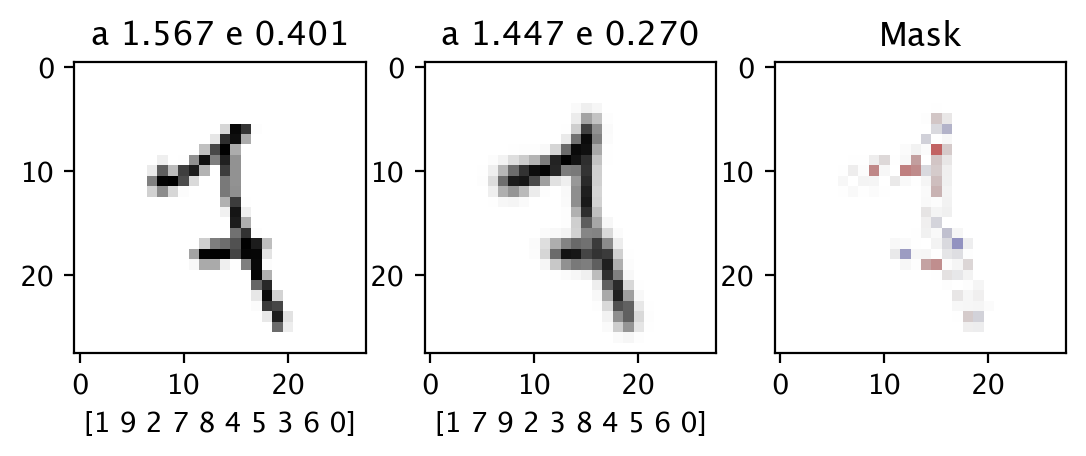

original aleatoric: 1.422 epistemic 0.484
original predictions [[2 7 9 5 8 4 0 3 6 1]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5288154].


explanation aleatoric: 1.252 epistemic 0.342
original predictions [[7 9 5 8 2 4 0 3 6 1]]
1


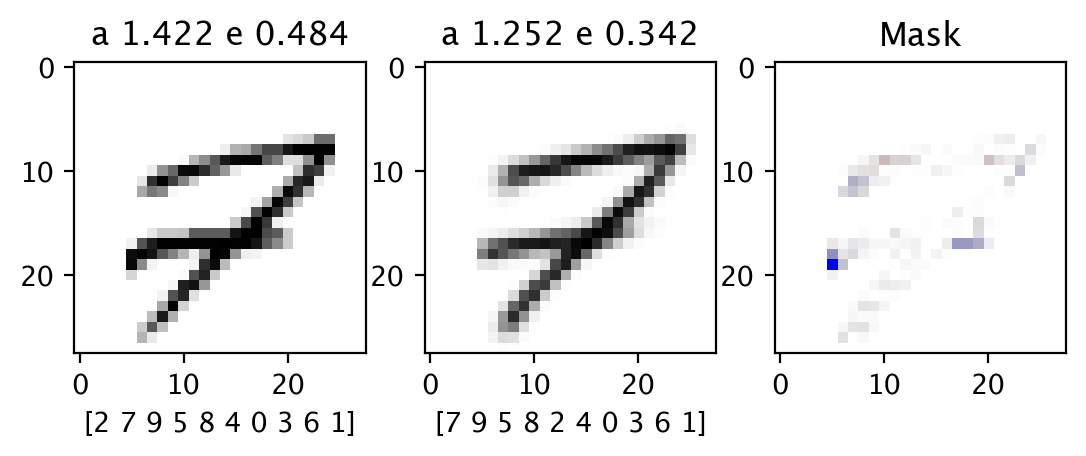

original aleatoric: 1.410 epistemic 0.485
original predictions [[5 8 2 4 1 3 0 6 7 9]]
explanation aleatoric: 1.538 epistemic 0.447
original predictions [[8 5 2 4 1 3 6 0 7 9]]
2


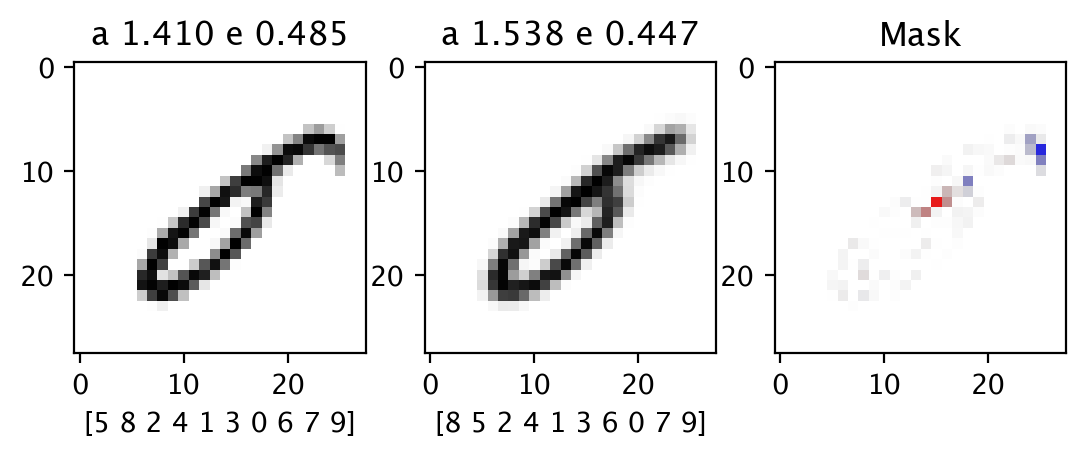

original aleatoric: 1.397 epistemic 0.493
original predictions [[2 8 9 3 6 5 0 4 7 1]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2527674].


explanation aleatoric: 1.390 epistemic 0.391
original predictions [[2 9 8 6 3 0 7 5 4 1]]
3


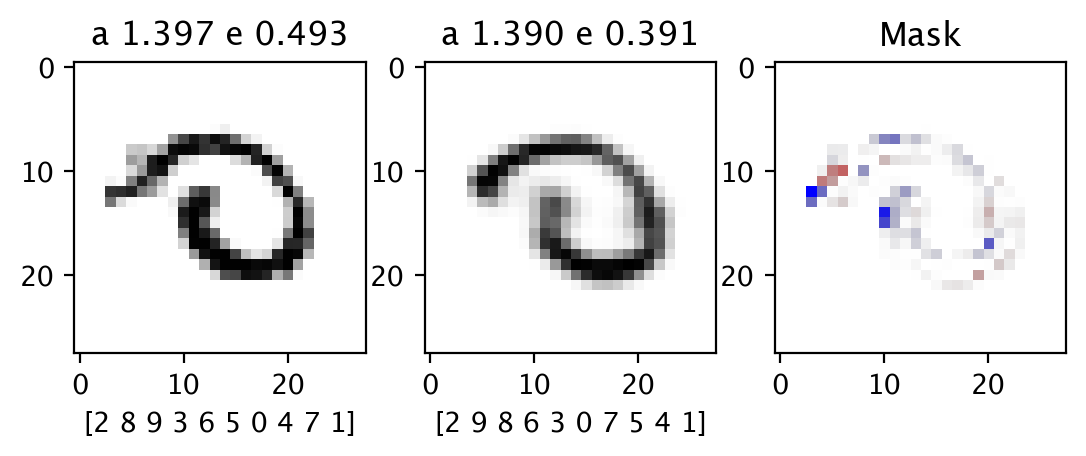

original aleatoric: 1.385 epistemic 0.473
original predictions [[4 2 9 3 8 5 1 6 7 0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4280602].


explanation aleatoric: 1.247 epistemic 0.358
original predictions [[4 2 9 8 3 5 6 1 7 0]]
4


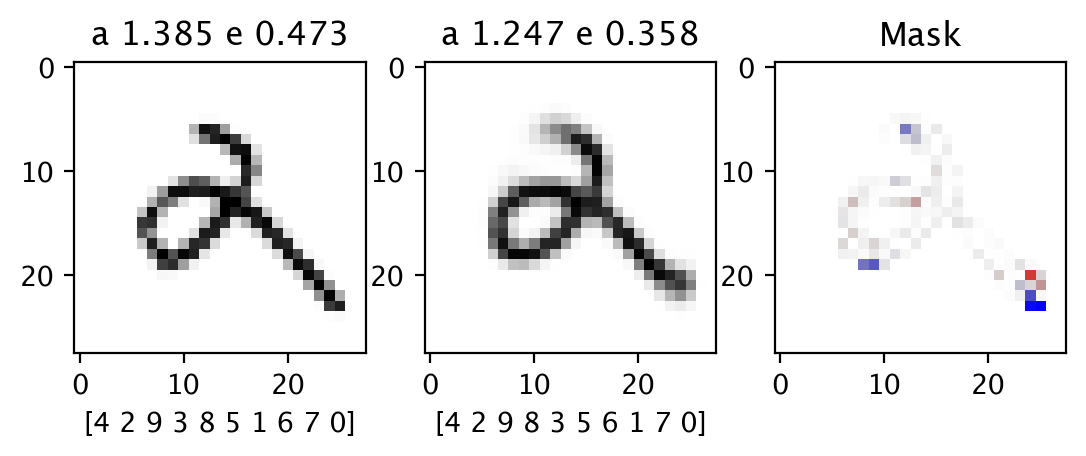

original aleatoric: 1.391 epistemic 0.436
original predictions [[9 8 1 3 7 4 5 6 2 0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6168092].


explanation aleatoric: 1.303 epistemic 0.300
original predictions [[1 9 8 7 3 4 5 2 6 0]]
5


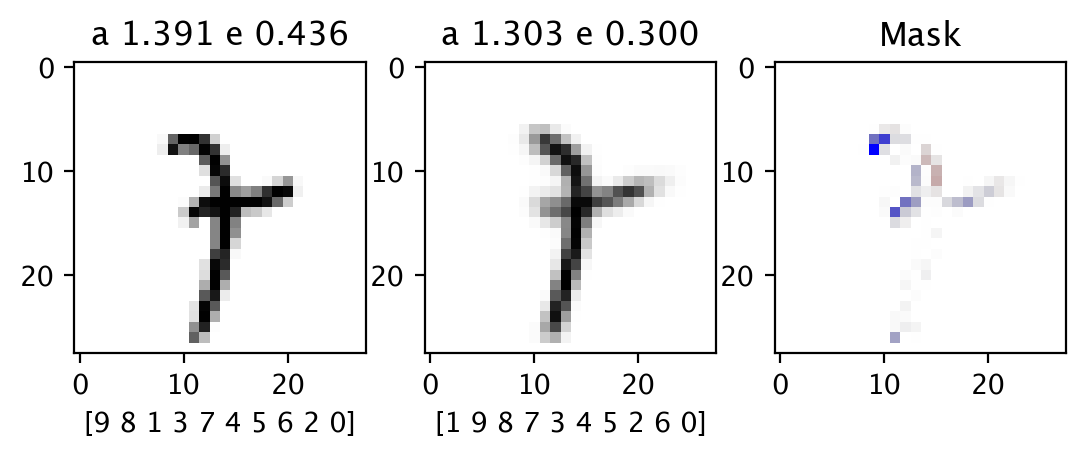

original aleatoric: 1.299 epistemic 0.527
original predictions [[3 5 4 0 6 2 8 9 1 7]]
explanation aleatoric: 1.217 epistemic 0.453
original predictions [[3 5 2 6 0 4 8 1 9 7]]
6


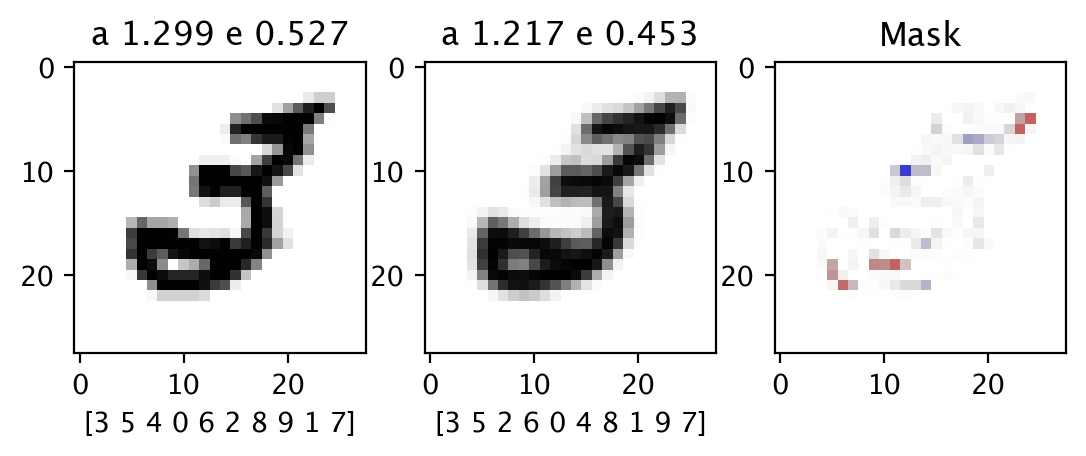

original aleatoric: 1.388 epistemic 0.432
original predictions [[0 3 6 5 7 2 4 1 9 8]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7394278].


explanation aleatoric: 1.153 epistemic 0.268
original predictions [[6 0 3 5 2 7 4 1 8 9]]
7


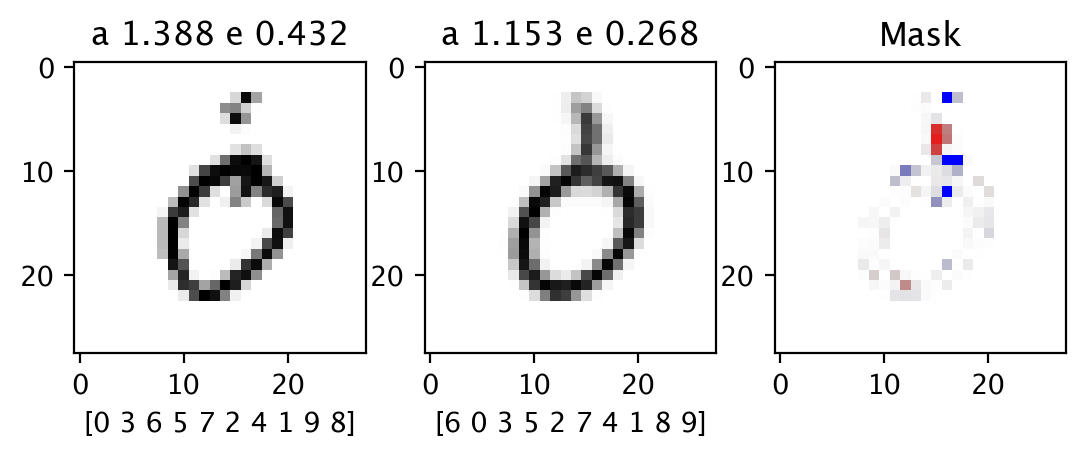

original aleatoric: 1.270 epistemic 0.470
original predictions [[8 4 3 2 5 9 7 1 6 0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5350703].


explanation aleatoric: 1.268 epistemic 0.330
original predictions [[8 3 4 9 2 7 5 1 6 0]]
8


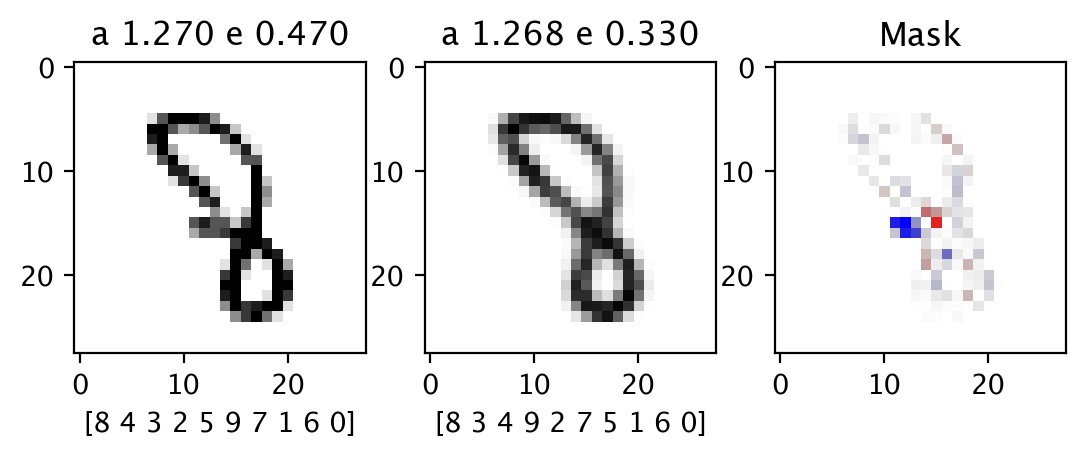

original aleatoric: 1.378 epistemic 0.350
original predictions [[9 3 4 8 5 7 1 2 0 6]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4939637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7589662].


explanation aleatoric: 1.612 epistemic 0.353
original predictions [[9 8 3 5 4 2 7 1 0 6]]
9


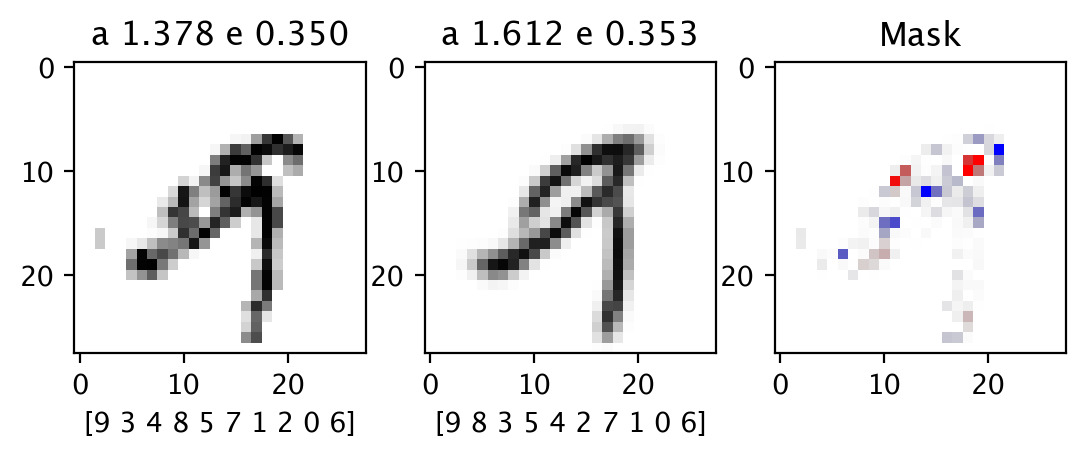

original aleatoric: 1.226 epistemic 0.492
original predictions [[8 1 7 2 3 9 5 4 0 6]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4795624].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4978167].


explanation aleatoric: 1.134 epistemic 0.401
original predictions [[7 8 1 2 3 9 4 5 0 6]]
10


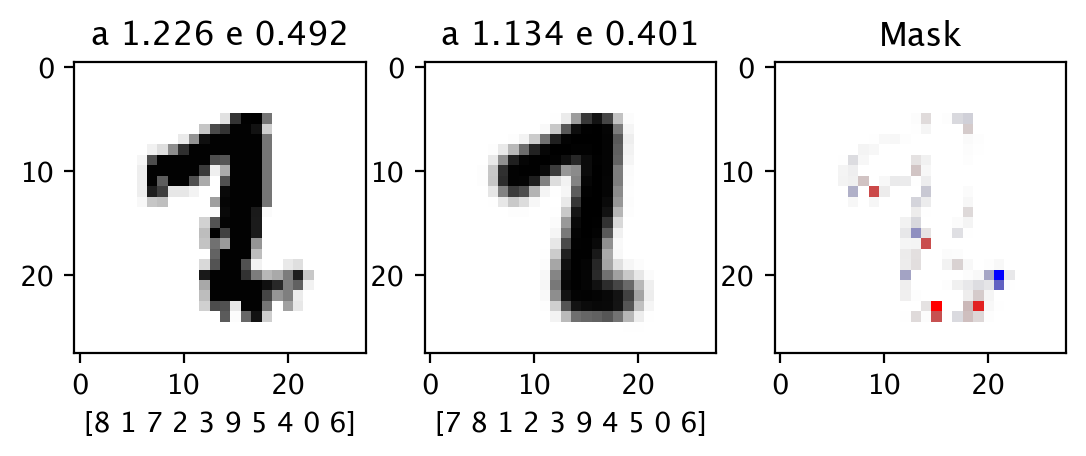

original aleatoric: 1.169 epistemic 0.546
original predictions [[0 4 1 6 7 2 5 3 8 9]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0346516].


explanation aleatoric: 1.118 epistemic 0.452
original predictions [[0 4 7 1 6 5 8 2 3 9]]
11


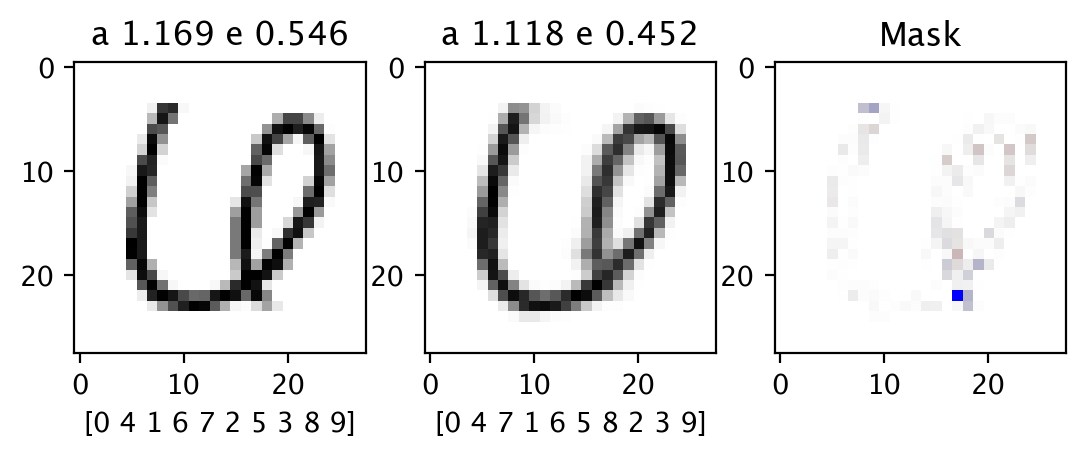

original aleatoric: 1.240 epistemic 0.464
original predictions [[8 6 1 5 2 3 0 9 4 7]]
explanation aleatoric: 1.210 epistemic 0.366
original predictions [[8 6 9 0 1 5 4 3 2 7]]
12


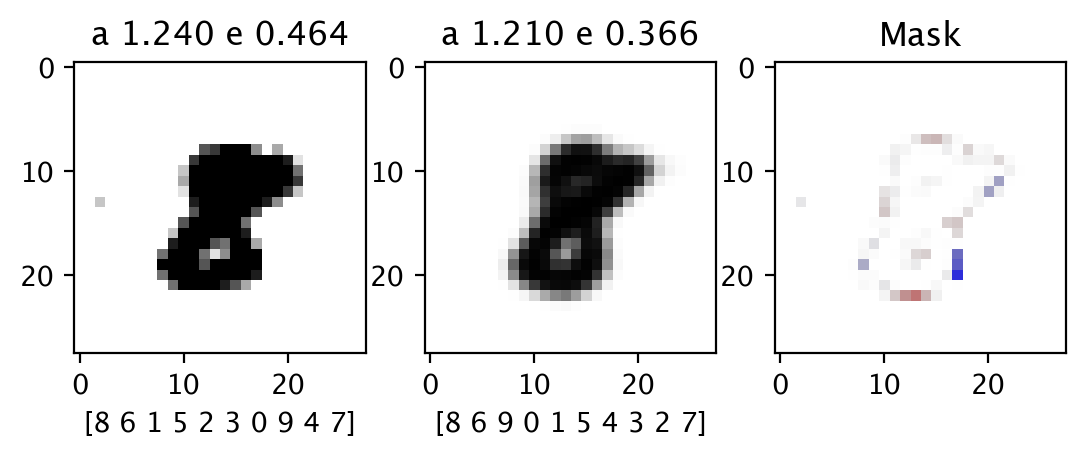

original aleatoric: 1.350 epistemic 0.349
original predictions [[2 7 1 3 8 5 6 9 4 0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3083098].


explanation aleatoric: 1.394 epistemic 0.306
original predictions [[2 7 1 3 8 9 6 4 5 0]]
13


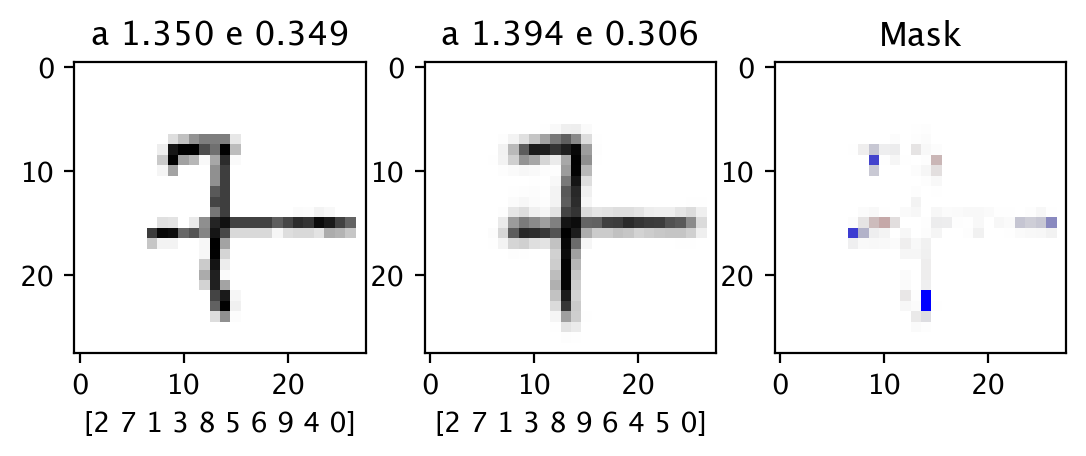

original aleatoric: 1.307 epistemic 0.382
original predictions [[4 8 7 2 1 3 9 6 5 0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1859916].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5678431].


explanation aleatoric: 1.416 epistemic 0.318
original predictions [[7 8 4 9 1 2 3 5 6 0]]
14


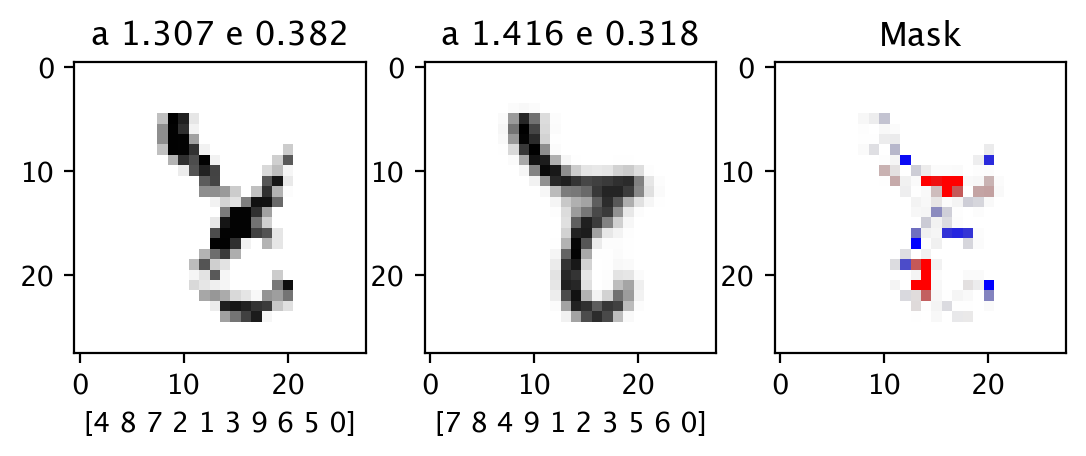

original aleatoric: 1.277 epistemic 0.407
original predictions [[9 8 7 4 5 1 3 0 6 2]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1200233].


explanation aleatoric: 1.074 epistemic 0.276
original predictions [[4 9 8 7 5 1 3 6 0 2]]
15


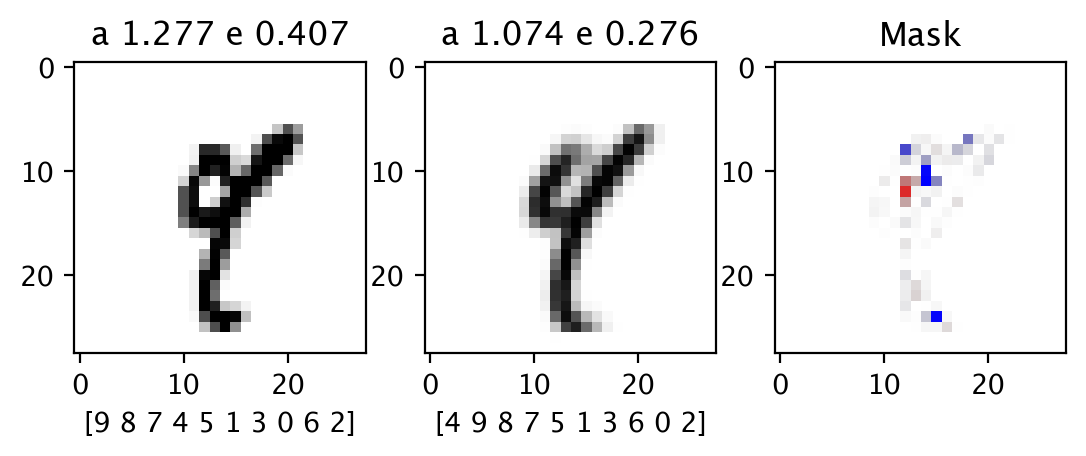

original aleatoric: 1.261 epistemic 0.422
original predictions [[7 1 3 9 8 2 4 6 5 0]]
explanation aleatoric: 1.317 epistemic 0.354
original predictions [[7 3 1 9 2 8 4 6 5 0]]
16


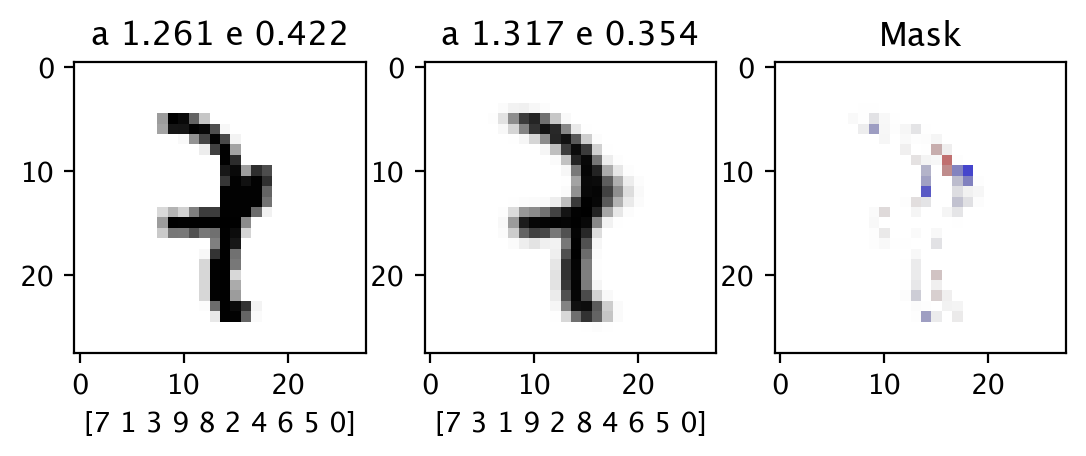

original aleatoric: 1.276 epistemic 0.400
original predictions [[8 1 4 2 5 9 7 6 3 0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2779956].


explanation aleatoric: 1.154 epistemic 0.298
original predictions [[8 1 2 4 7 9 5 6 3 0]]
17


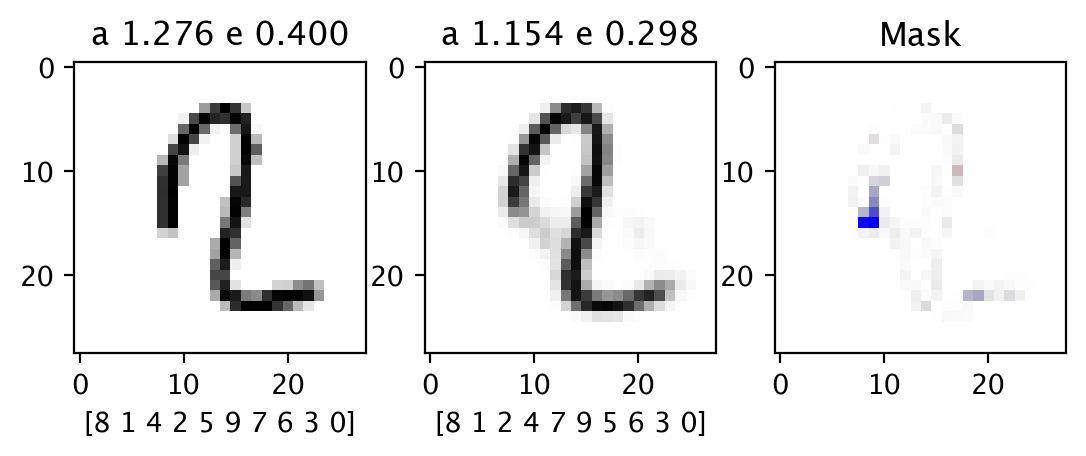

original aleatoric: 1.350 epistemic 0.320
original predictions [[3 5 9 7 4 8 1 2 6 0]]
explanation aleatoric: 1.148 epistemic 0.243
original predictions [[3 5 9 8 4 7 1 2 6 0]]
18


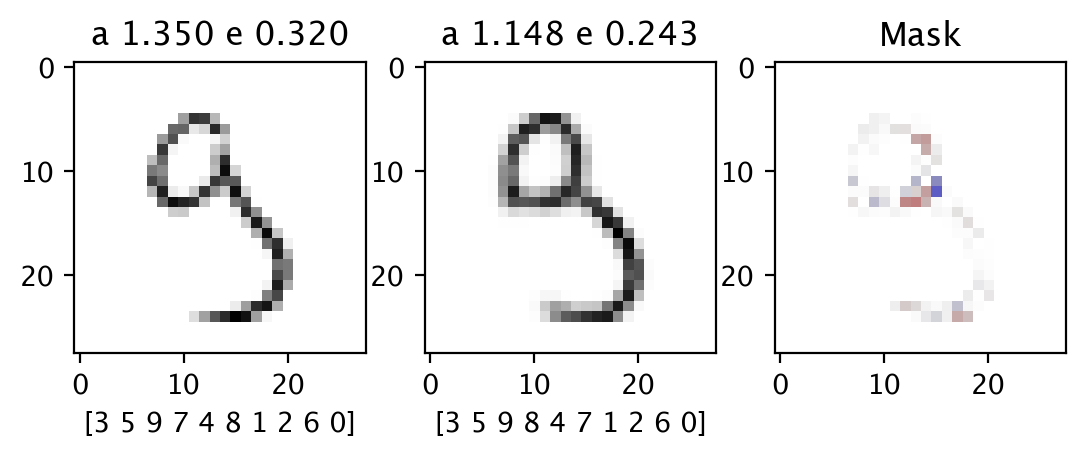

original aleatoric: 1.292 epistemic 0.376
original predictions [[3 9 5 8 0 1 2 7 4 6]]
explanation aleatoric: 1.003 epistemic 0.238
original predictions [[9 8 3 5 4 1 7 0 2 6]]
19


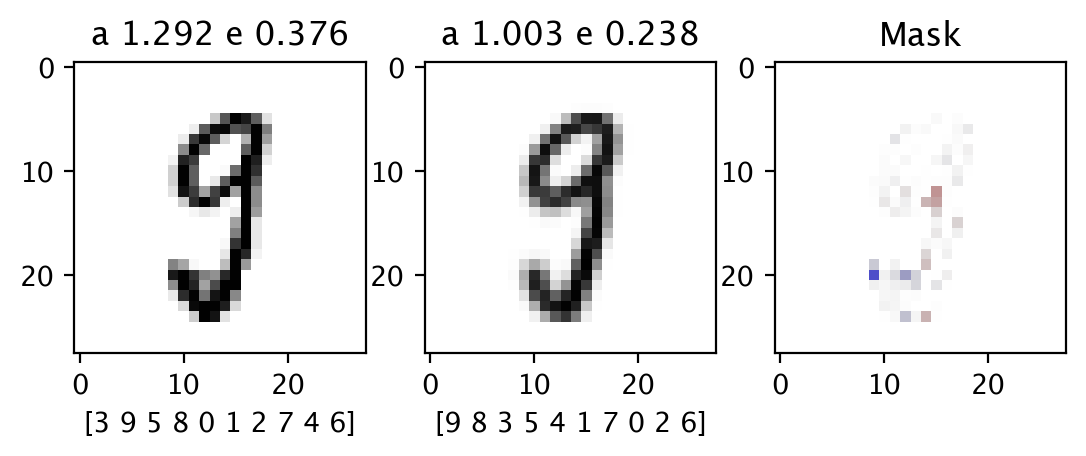

original aleatoric: 1.287 epistemic 0.363
original predictions [[5 3 4 9 8 1 7 6 2 0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8939198].


explanation aleatoric: 0.804 epistemic 0.239
original predictions [[5 4 3 8 1 9 6 2 7 0]]
20


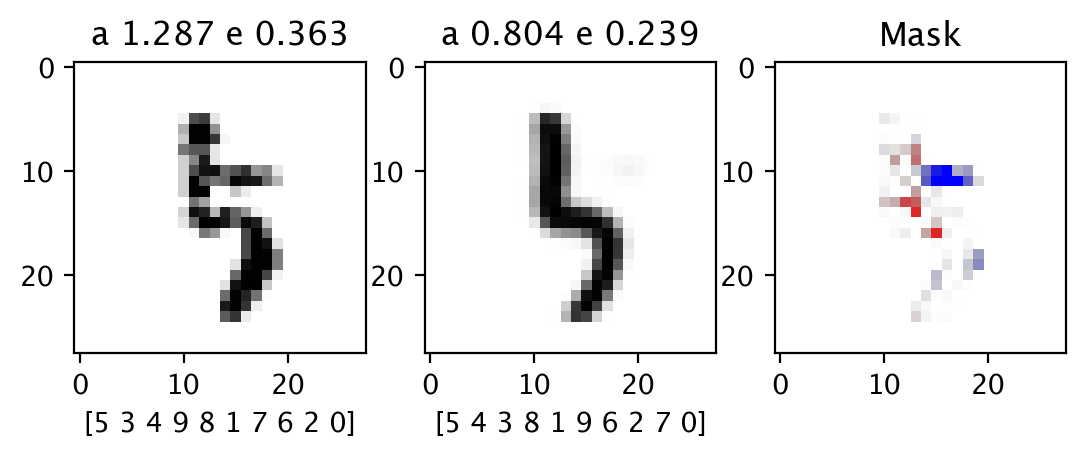

original aleatoric: 1.291 epistemic 0.358
original predictions [[1 8 9 4 7 3 2 6 5 0]]
explanation aleatoric: 1.177 epistemic 0.291
original predictions [[1 9 8 4 7 3 2 5 6 0]]
21


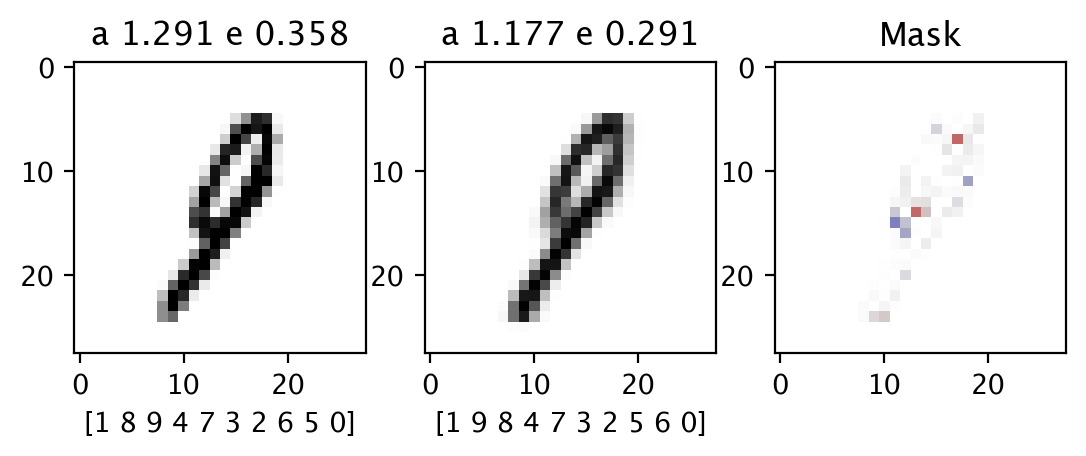

original aleatoric: 1.187 epistemic 0.459
original predictions [[9 5 8 4 6 3 7 0 2 1]]
explanation aleatoric: 1.083 epistemic 0.355
original predictions [[5 8 9 6 4 3 7 0 2 1]]
22


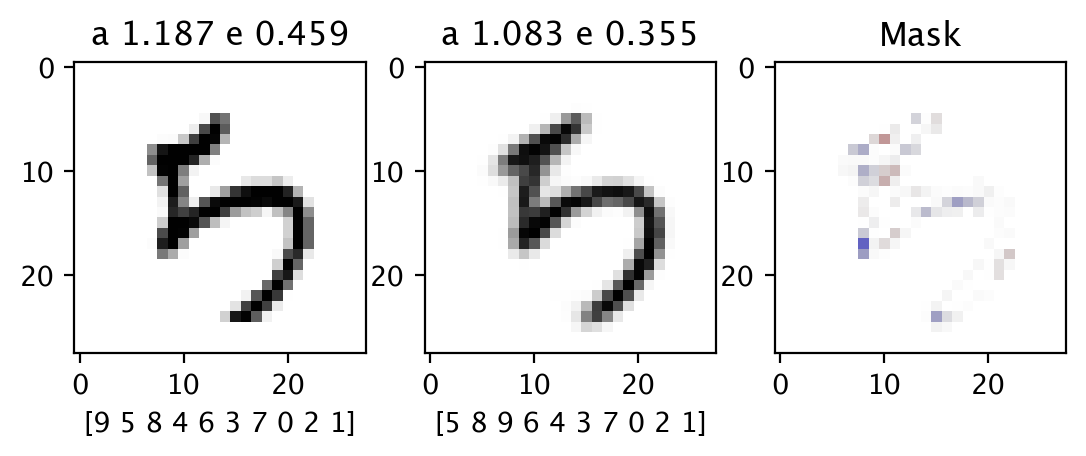

original aleatoric: 1.179 epistemic 0.455
original predictions [[4 0 6 7 2 1 9 8 5 3]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6439292].


explanation aleatoric: 1.082 epistemic 0.329
original predictions [[6 0 4 7 2 5 8 9 1 3]]
23


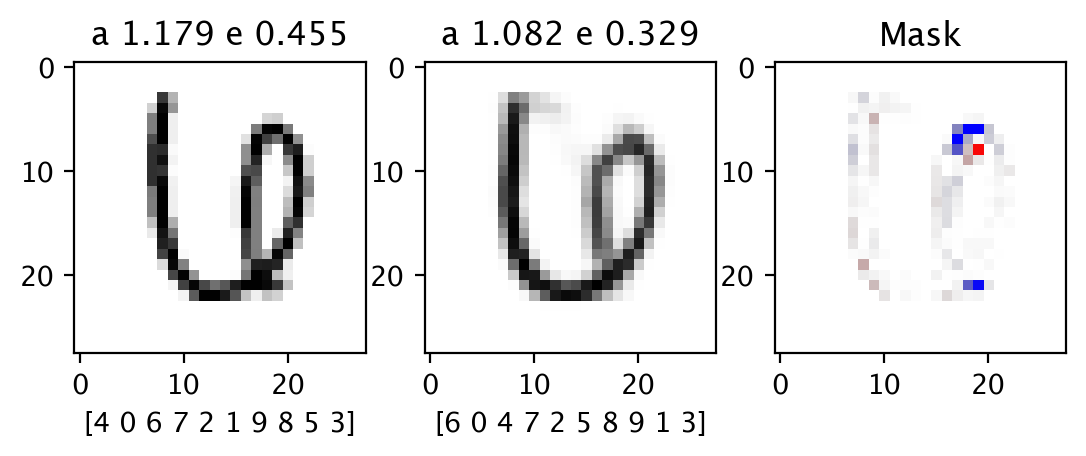

original aleatoric: 1.241 epistemic 0.381
original predictions [[3 8 5 2 1 9 7 0 4 6]]
explanation aleatoric: 1.171 epistemic 0.325
original predictions [[8 3 2 5 1 9 0 7 6 4]]
24


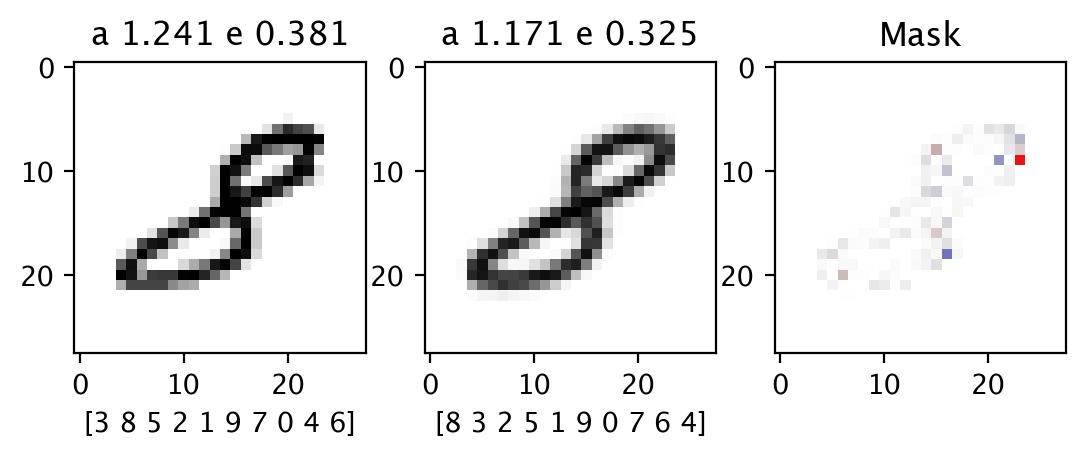

original aleatoric: 1.102 epistemic 0.518
original predictions [[5 2 3 6 8 1 7 4 0 9]]
explanation aleatoric: 1.128 epistemic 0.412
original predictions [[5 3 2 8 6 7 1 4 9 0]]
25


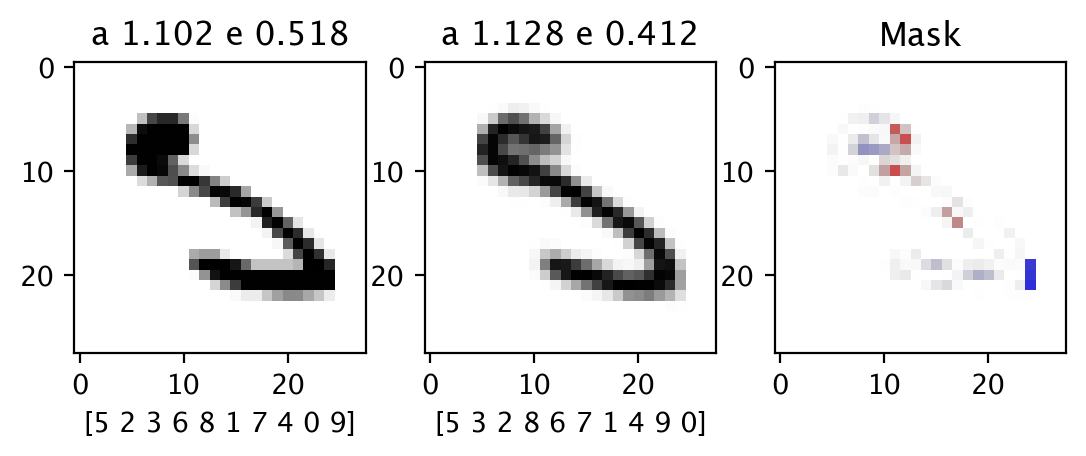

original aleatoric: 1.252 epistemic 0.368
original predictions [[8 2 7 5 9 0 3 6 4 1]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2001096].


explanation aleatoric: 0.867 epistemic 0.179
original predictions [[8 9 7 2 5 3 0 4 6 1]]
26


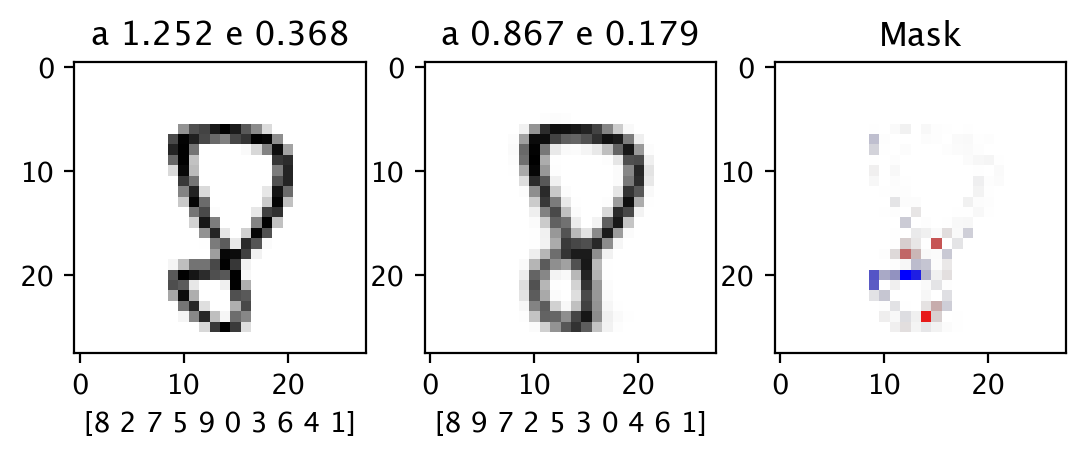

original aleatoric: 1.125 epistemic 0.482
original predictions [[2 9 8 3 4 7 0 5 6 1]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5115935].


explanation aleatoric: 1.135 epistemic 0.386
original predictions [[9 2 8 3 7 4 0 5 6 1]]
27


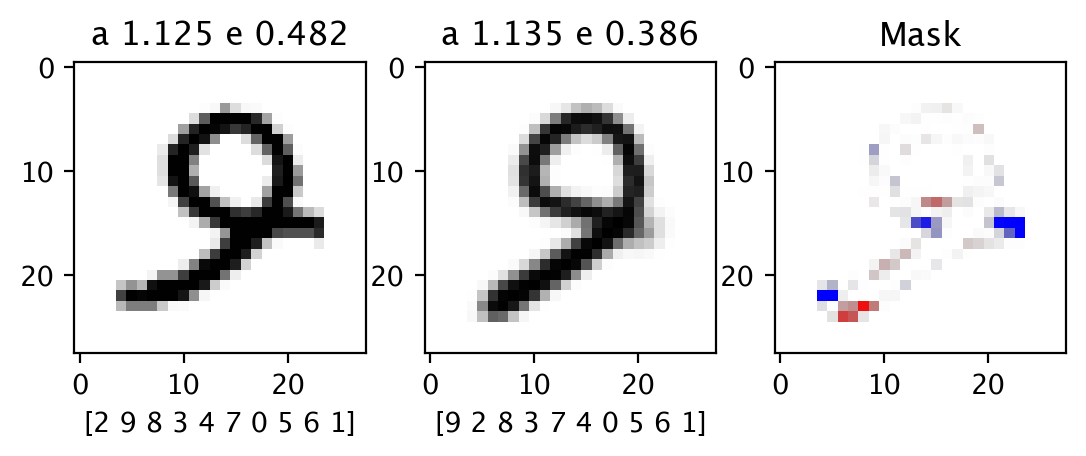

original aleatoric: 1.184 epistemic 0.424
original predictions [[9 8 5 3 0 2 7 1 6 4]]
explanation aleatoric: 1.206 epistemic 0.365
original predictions [[8 9 3 5 0 2 7 1 6 4]]
28


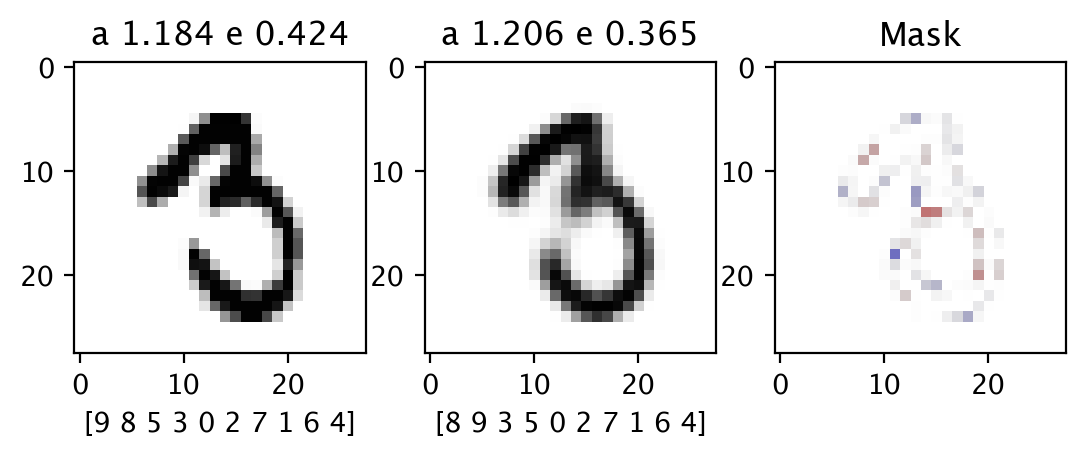

original aleatoric: 1.278 epistemic 0.327
original predictions [[0 8 2 6 5 9 4 1 3 7]]
explanation aleatoric: 1.251 epistemic 0.288
original predictions [[0 8 2 6 9 4 5 1 3 7]]
29


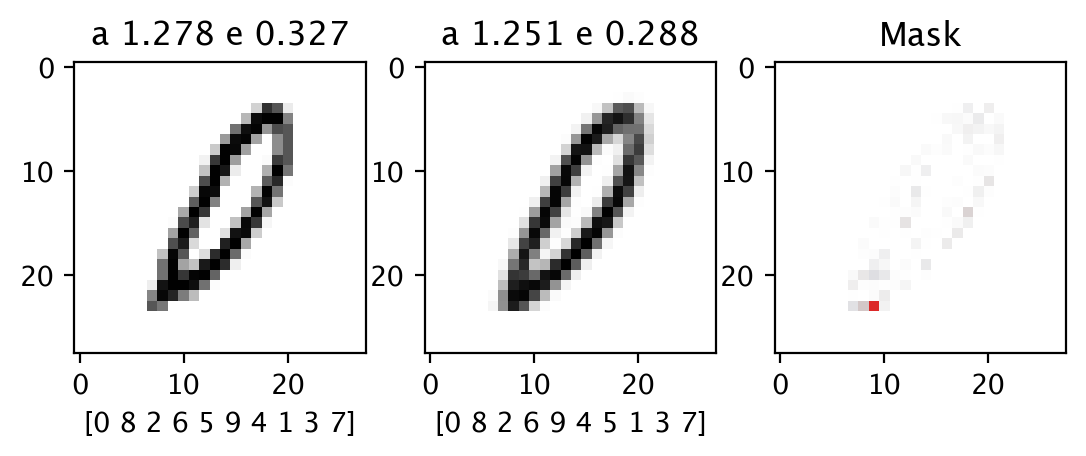

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5079818].


original aleatoric: 1.027 epistemic 0.578
original predictions [[9 0 5 8 3 2 4 6 7 1]]
explanation aleatoric: 0.959 epistemic 0.481
original predictions [[9 5 0 8 3 2 4 6 7 1]]
30


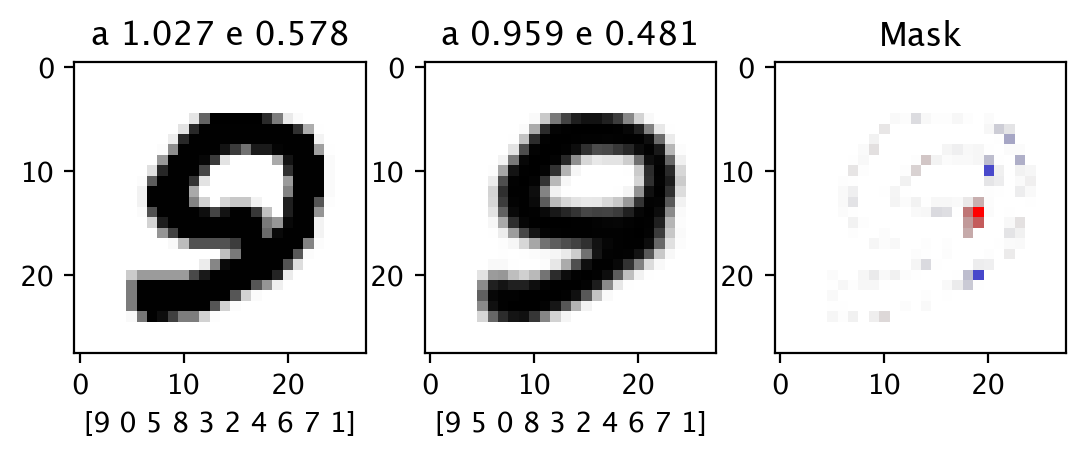

original aleatoric: 1.247 epistemic 0.357
original predictions [[9 7 2 3 5 4 6 8 1 0]]
explanation aleatoric: 1.217 epistemic 0.305
original predictions [[9 2 4 7 5 3 6 8 1 0]]
31


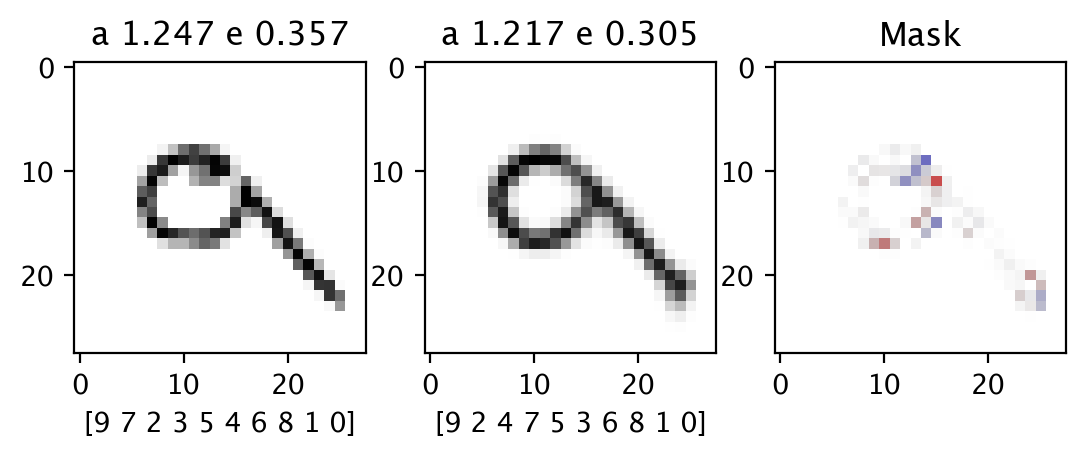

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4856718].


original aleatoric: 1.259 epistemic 0.341
original predictions [[8 9 3 5 2 7 4 1 6 0]]
explanation aleatoric: 0.920 epistemic 0.178
original predictions [[8 9 4 5 2 3 7 1 6 0]]
32


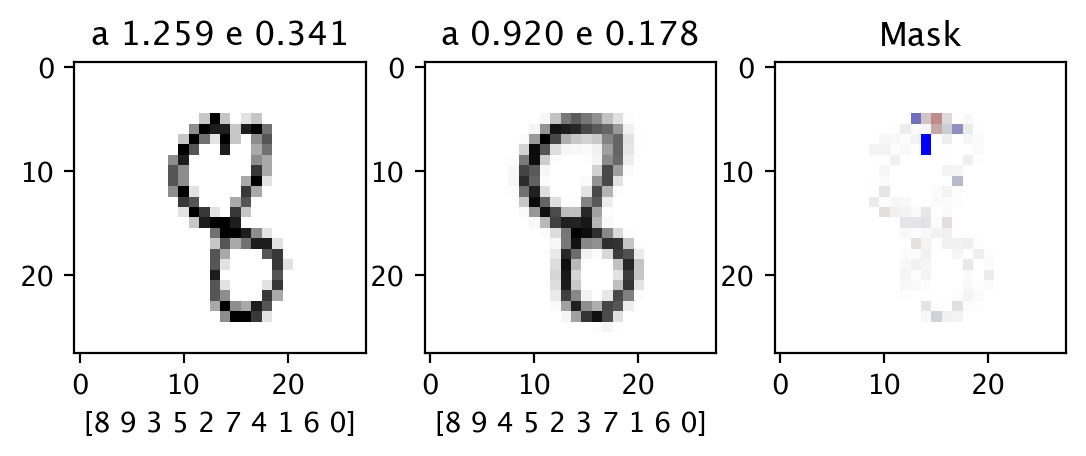

original aleatoric: 1.134 epistemic 0.463
original predictions [[3 0 5 8 2 6 9 7 1 4]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3545945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0903857].


explanation aleatoric: 1.178 epistemic 0.392
original predictions [[8 3 5 0 6 2 9 1 7 4]]
33


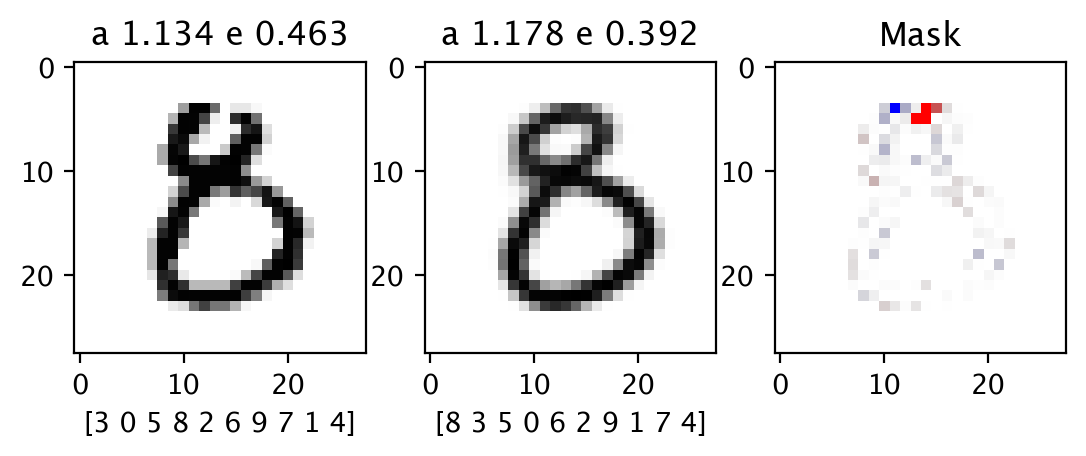

original aleatoric: 1.149 epistemic 0.447
original predictions [[3 8 1 7 2 5 0 9 4 6]]
explanation aleatoric: 1.081 epistemic 0.334
original predictions [[8 3 1 7 2 5 9 0 4 6]]
34


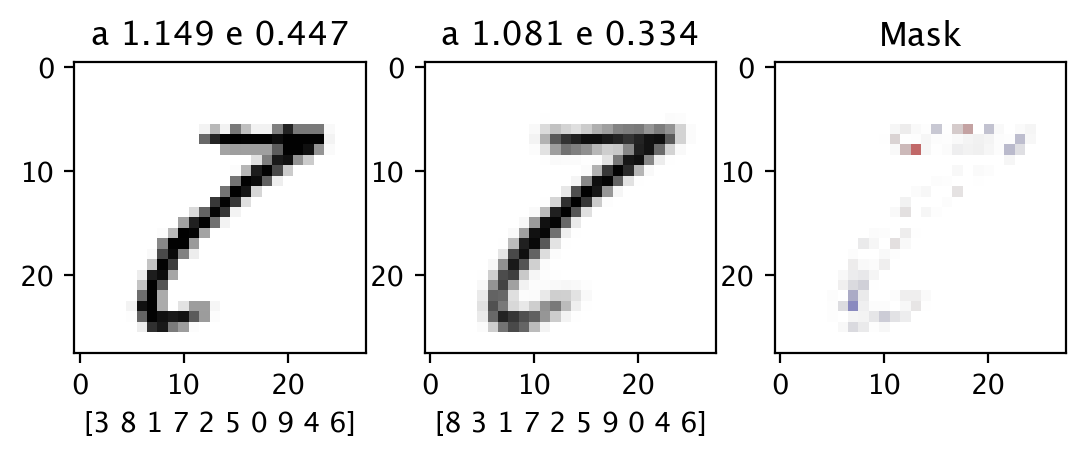

original aleatoric: 1.227 epistemic 0.367
original predictions [[5 9 3 4 8 7 0 6 2 1]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.253195].


explanation aleatoric: 1.058 epistemic 0.279
original predictions [[5 9 3 4 8 7 0 6 1 2]]
35


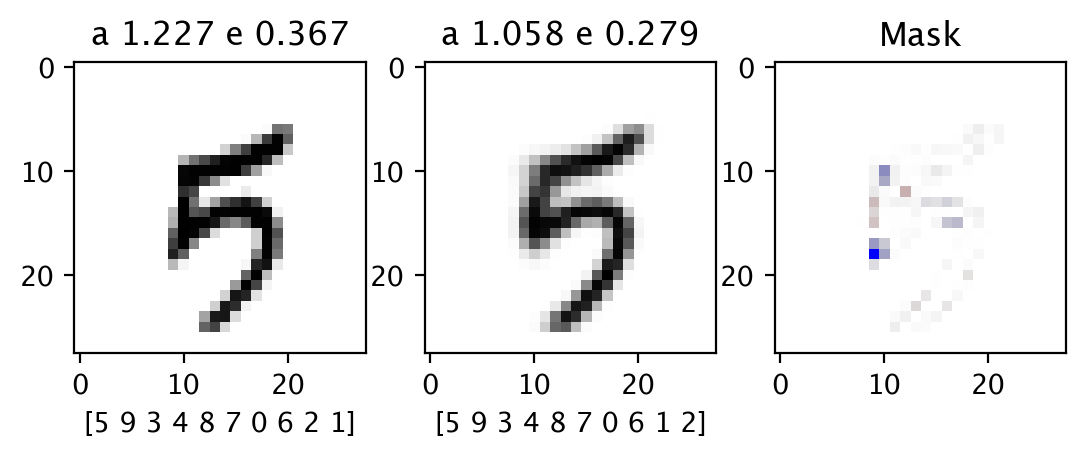

original aleatoric: 1.170 epistemic 0.423
original predictions [[3 2 0 4 9 7 8 5 1 6]]
explanation aleatoric: 0.991 epistemic 0.329
original predictions [[3 2 0 4 9 8 7 5 1 6]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1790953].


36


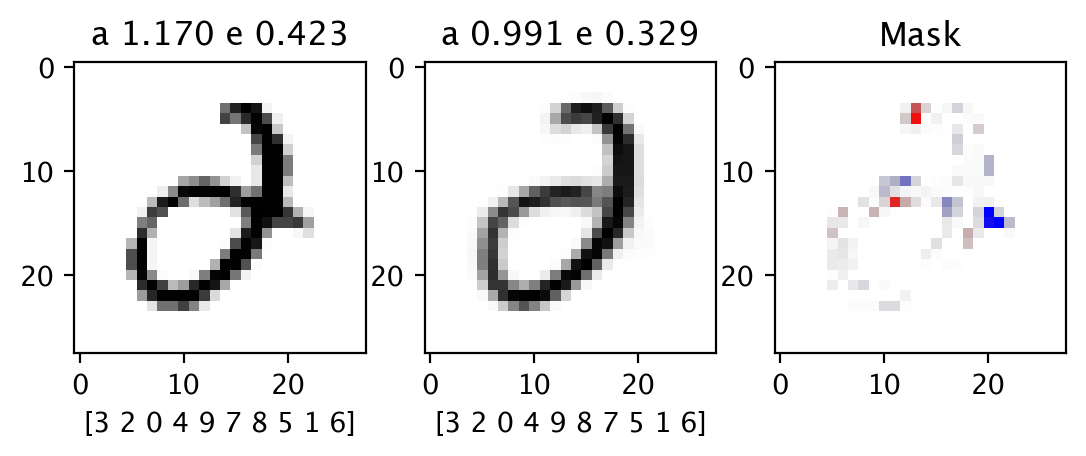

original aleatoric: 1.192 epistemic 0.400
original predictions [[4 9 7 1 8 5 3 0 6 2]]
explanation aleatoric: 1.159 epistemic 0.339
original predictions [[4 9 7 1 8 5 3 0 6 2]]
37


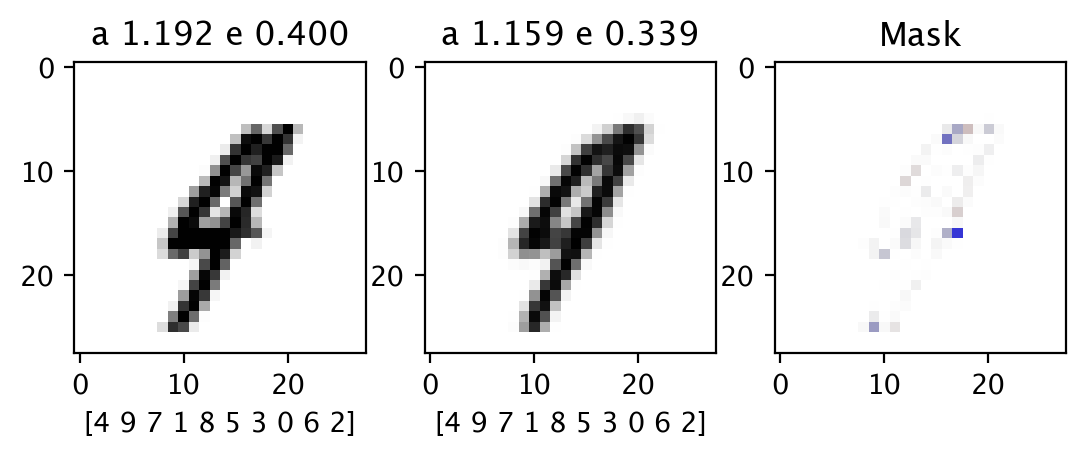

original aleatoric: 1.198 epistemic 0.393
original predictions [[2 8 6 1 5 4 0 9 7 3]]
explanation aleatoric: 1.211 epistemic 0.306
original predictions [[2 6 8 4 5 1 0 9 3 7]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.180979].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1524909].


38


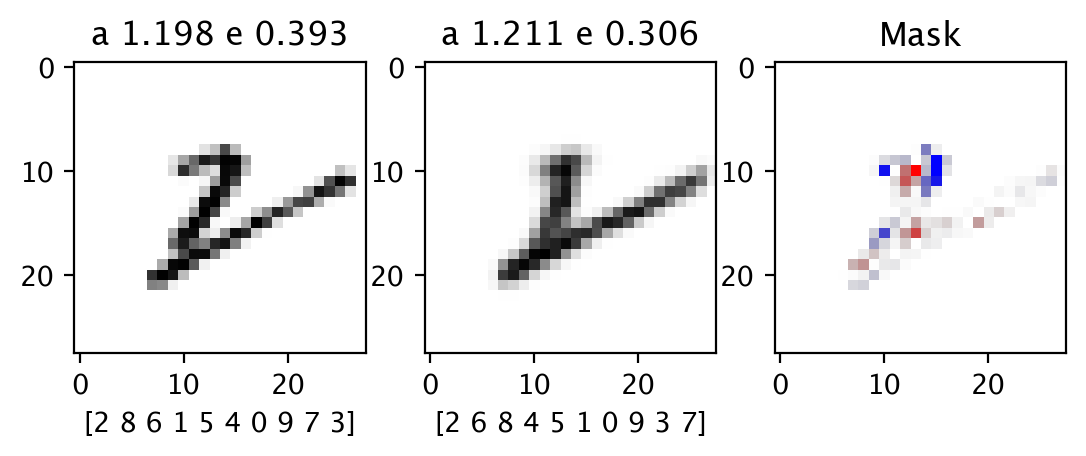

original aleatoric: 1.207 epistemic 0.378
original predictions [[2 7 1 8 3 9 4 0 6 5]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3548547].


explanation aleatoric: 1.206 epistemic 0.342
original predictions [[7 2 8 3 1 9 0 4 5 6]]
39


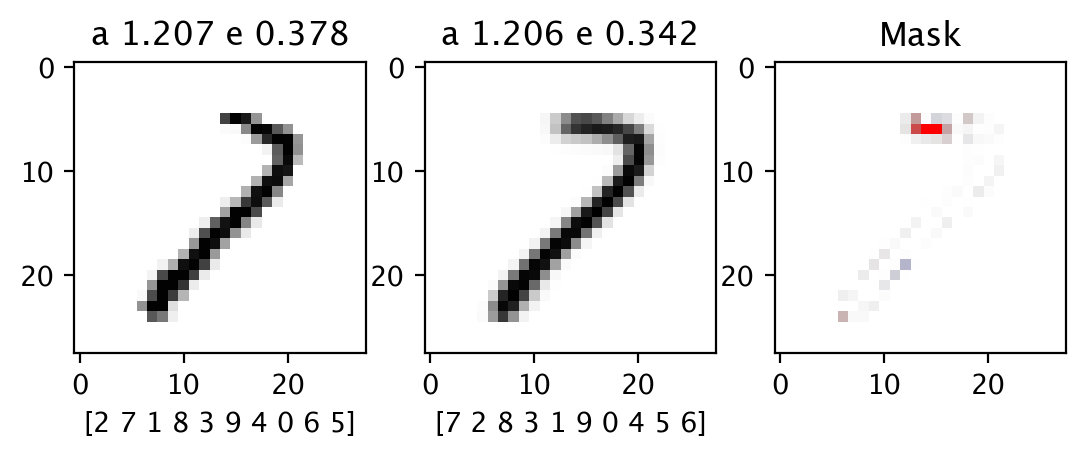

In [ ]:

from src.probability import decompose_entropy_cat
from src.utils import MNIST_mean_std_norm


o_uncert_tosave = []
o_class_tosave = []
post_uncert_tosave = []
post_class_tosave = []
x_start_tosave = []
x_end_tosave = []


for N_explain in range(Nbatch):

    to_BNN = MNIST_mean_std_norm(torch.tensor(x_test[uncert_idxs_sorted[N_explain],0,:,:]).view(1,-1)).to(BNN.device)
    probs = BNN.sample_predict(to_BNN, Nsamples=0, grad=False)
    o_total_entropy, o_aleatoric_entropy, o_epistemic_entropy = decompose_entropy_cat(probs)
    print('original aleatoric: %2.3f epistemic %2.3f' % (o_aleatoric_entropy.item(), o_epistemic_entropy.item()))
    _, o_preds = probs.mean(dim=0).sort(dim=1, descending=True)
    print('original predictions', o_preds.cpu().numpy())


    fig, ax = plt.subplots(nrows=1, ncols=3, dpi=200)
    ax[0].imshow(1-x_test[uncert_idxs_sorted[N_explain],0,:,:], cmap='gray')
    ax[0].set_title('a %2.3f e %2.3f' % (o_aleatoric_entropy.item(), o_epistemic_entropy.item()))
    ax[0].set_xlabel(o_preds.cpu().numpy()[0])


    to_BNN = MNIST_mean_std_norm(torch.tensor(x_vec[-1,N_explain,0,:,:]).view(1,-1)).to(BNN.device)
    probs = BNN.sample_predict(to_BNN, Nsamples=0, grad=False)
    total_entropy, aleatoric_entropy, epistemic_entropy = decompose_entropy_cat(probs)
    print('explanation aleatoric: %2.3f epistemic %2.3f' % (aleatoric_entropy.item(), epistemic_entropy.item()))
    _, preds = probs.mean(dim=0).sort(dim=1, descending=True)
    print('original predictions', preds.cpu().numpy())


    ax[1].imshow(1-x_vec[-1,N_explain,0,:,:], cmap='gray')
    ax[1].set_title('a %2.3f e %2.3f' % (aleatoric_entropy.item(), epistemic_entropy.item()))
    ax[1].set_xlabel(preds.cpu().numpy()[0])

    mask = x_vec[-1] - x_init_batch

    mask_neg = -mask[N_explain,0,:,:]
    mask_neg[mask_neg < 1e-3] = 0
    mask_neg = (mask_neg**2)
    mask_neg = np.repeat(np.expand_dims(mask_neg, axis=2), 4, axis=2)*2
    mask_neg[:,:,0:2] = 0

    mask_pos = mask[N_explain,0,:,:]
    mask_pos[mask_pos < 1e-3] = 0
    mask_pos = mask_pos**2
    mask_pos = np.repeat(np.expand_dims(mask_pos, axis=2), 4, axis=2)*2
    mask_pos[:,:,1:3] = 0


    # ax[2].imshow(1-x_init_batch[N_explain, 0,:,:], cmap='gray')
    ax[2].imshow(mask_pos, alpha=1)#,  vmin=0, vmax=1)
    ax[2].imshow(mask_neg, alpha=1)
    ax[2].set_title('Mask')

    print(N_explain)
    plt.show()

    o_uncert_tosave.append(o_total_entropy.data.cpu().numpy())
    o_class_tosave.append(o_preds.data.cpu().numpy())
    post_uncert_tosave.append(total_entropy.data.cpu().numpy())
    post_class_tosave.append(preds.data.cpu().numpy())
    x_start_tosave.append(x_test[uncert_idxs_sorted[N_explain],0,:,:])
    x_end_tosave.append(x_vec[-1,N_explain,0,:,:])


o_uncert_tosave = np.stack(o_uncert_tosave, axis=0)
o_class_tosave = np.stack(o_class_tosave, axis=0)
post_uncert_tosave = np.stack(post_uncert_tosave, axis=0)
post_class_tosave = np.stack(post_class_tosave, axis=0)
x_start_tosave = np.stack(x_start_tosave, axis=0)
x_end_tosave = np.stack(x_end_tosave, axis=0)




In [ ]:
plt.figure(figsize=(10,6))
plt.hist(o_uncert_tosave, bins=30, alpha=0.7, label='Original Uncertainties')
plt.xlabel('Uncertainty Value')
plt.ylabel('Count')
plt.title('Distribution of Original Prediction Uncertainties')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10,6))
plt.hist(post_uncert_tosave, bins=30, alpha=0.7, label='Post-CLUE Uncertainties')
plt.xlabel('Uncertainty Value')
plt.ylabel('Count')
plt.title('Distribution of Post-CLUE Prediction Uncertainties')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

